In [30]:
import torch
import os 

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchmetrics import functional as FM

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

### 전이학습

In [31]:
import torchvision.models as models
from torchvision.datasets import CIFAR10

In [32]:
train_cifar = CIFAR10(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
test_cifar = CIFAR10(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [33]:
batch_size = 256
train_dataloader = DataLoader(train_cifar, batch_size=batch_size)
test_dataloader = DataLoader(test_cifar, batch_size=batch_size)

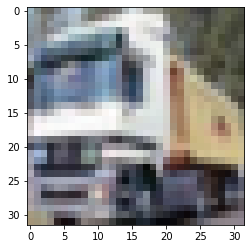

In [34]:
plt.imshow(np.transpose(train_cifar[1][0], (1,2,0)))

In [51]:
class ImagenetTransferLearning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        backbone = models.resnet50(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        
        num_target_classes = 10
        self.classifier = nn.Linear(num_filters, num_target_classes)
    
    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x
        
    def training_step(self, batch, batch_idx):
        X,y = batch
        logits = self.forward(X)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        acc = FM.accuracy(pred, y)
        loss = F.cross_entropy(pred, y)
        self.log("test_loss", loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        if self.pretrain:
            optimizer = torch.optim.NAdam(self.parameters())
        else:
            optimizer = torch.optim.NAdam(self.parameters(), lr=2e-4)
        return optimizer
    
    def set_pretrain(self, pretrain=True):
        self.pretrain = pretrain

In [52]:
pretrained_model = ImagenetTransferLearning()

In [53]:
print(pretrained_model)

ImagenetTransferLearning(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [55]:
for child in pretrained_model.feature_extractor:
    for params in child.parameters():
        params.requires_grad = False

In [56]:
pretrained_model.set_pretrain(True)

In [57]:
trainer = pl.Trainer(max_epochs=5, accelerator="gpu", devices=1)
trainer.fit(pretrained_model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M
1 | classifier        | Linear     | 20.5 K
-------------------------------------------------
20.5 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 196/196 [00:20<00:00,  9.65it/s, loss=0.973, v_num=25]


In [58]:
pretrained_model.set_pretrain(False)

In [59]:
for child in pretrained_model.feature_extractor:
    for params in child.parameters():
        params.requires_grad = True

In [60]:
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=1)
trainer.fit(pretrained_model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M
1 | classifier        | Linear     | 20.5 K
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 196/196 [00:20<00:00,  9.42it/s, loss=0.872, v_num=26]


In [61]:
pretrained_model.eval()

ImagenetTransferLearning(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [62]:
trainer.test(pretrained_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 40/40 [00:04<00:00,  8.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6413999795913696
        test_loss           1.0353018045425415
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0353018045425415, 'test_acc': 0.6413999795913696}]

In [63]:
cifar_classes = test_cifar.classes

In [71]:
cifar_classes[pretrained_model(test_cifar[1][0][None, :]).argmax().item()]

'ship'

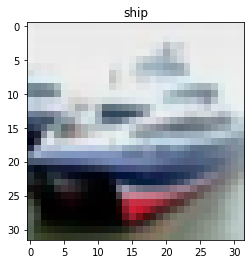

In [72]:
plt.title(cifar_classes[test_cifar[1][1]])
plt.imshow(np.transpose(test_cifar[1][0], (1, 2, 0)))